In [ ]:
# ========================================================
# Project: Credit Risk and Loan Approval Analysis  (Advanced Models)
# Author: Karri Vamsi
# Date: July 27, 2025
# Description: Predict Loan Approval and Credit Risk using ANN (Deep learning).
# Dataset: financial-risk-for-loan-approval.csv from Kaggle
# ========================================================

In [15]:
# =====================
# 1. Import Libraries
# =====================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# =====================
# 2. Load Dataset
# =====================

df = pd.read_csv('/Users/dumsi/Downloads/Loan.csv')

In [3]:
# =====================
# 3. Train-Test Split (Stratified on Classification Label)
# =====================

train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['LoanApproved'],random_state=25)

In [4]:
# =====================
# 4. Drop Irrelevant Columns
# =====================

train_df = train_df.drop(columns=['ApplicationDate'])
test_df = test_df.drop(columns=['ApplicationDate'])

In [5]:
# =====================
# 5. Split Features and Targets
# =====================

X_train_raw = train_df.drop(columns=['LoanApproved', 'RiskScore'])
y_train = {
    'Loan_approved': train_df['LoanApproved'],
    'Risk_score': train_df['RiskScore']
}

X_test_raw = test_df.drop(columns=['LoanApproved', 'RiskScore'])
y_test = {
    'Loan_approved': test_df['LoanApproved'],
    'Risk_score': test_df['RiskScore']
}


In [6]:
# =====================
# 6. Preprocessing Pipeline
# =====================

# Define categorical columns
categorical_cols = ['EmploymentStatus', 'EducationLevel', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose']

# Build ColumnTransformer for encoding + scaling
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(), categorical_cols)
], remainder='passthrough')

# Combine with MinMaxScaler in a pipeline
pipeline = Pipeline([
    ('transform', preprocessor),
    ('scale', MinMaxScaler())
])

# Fit-transform training data
X_train_array = pipeline.fit_transform(X_train_raw)

# Get one-hot encoded column names
ohe_features = preprocessor.named_transformers_['onehot'].get_feature_names_out(categorical_cols).tolist()

# Include numeric columns
numeric_cols = [col for col in X_train_raw.columns if col not in categorical_cols]
final_columns = ohe_features + numeric_cols

# Convert transformed arrays to DataFrames
X_train = pd.DataFrame(X_train_array, columns=final_columns, index=X_train_raw.index)

# Transform test data using the same pipeline
X_test_array = pipeline.transform(X_test_raw)
X_test = pd.DataFrame(X_test_array, columns=final_columns, index=X_test_raw.index)

In [7]:
# =====================
# 7. Define Neural Network (Functional API)
# =====================

input_layer = keras.layers.Input(shape=(X_train.shape[1],))
x = keras.layers.BatchNormalization()(input_layer)
x = keras.layers.Dense(200, activation='relu', kernel_initializer='he_uniform')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(170, activation='relu', kernel_initializer='he_uniform')(x)
x = keras.layers.BatchNormalization()(x)

# Output 1: Classification
output_class = keras.layers.Dense(1, activation='sigmoid', name='Loan_approved')(x)

# Output 2: Regression
output_score = keras.layers.Dense(1, activation='relu', name='Risk_score')(x)

# Build model
model = keras.Model(inputs=input_layer, outputs=[output_class, output_score])

2025-07-27 07:39:42.479318: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-07-27 07:39:42.479351: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-07-27 07:39:42.479358: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-07-27 07:39:42.479391: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-27 07:39:42.479401: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
# =====================
# 8. Compile Model
# =====================

model.compile(
    loss={'Loan_approved': 'binary_crossentropy', 'Risk_score': 'mean_absolute_error'},
    optimizer='adam',
    metrics={'Loan_approved': 'accuracy', 'Risk_score': 'mae'}
)

In [9]:
# =====================
# 9. Train Model
# =====================

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.3,
    epochs=30,
    callbacks=[early_stop]
)
print(history)

Epoch 1/30


2025-07-27 07:39:43.674304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


307/307 ━━━━━━━━━━━━━━━━━━━━ 31s 53ms/step - Loan_approved_accuracy: 0.8022 - Loan_approved_loss: 0.4198 - Risk_score_loss: 42.7341 - Risk_score_mae: 42.7343 - loss: 43.1541 - val_Loan_approved_accuracy: 0.8564 - val_Loan_approved_loss: 0.3155 - val_Risk_score_loss: 22.4663 - val_Risk_score_mae: 22.5092 - val_loss: 22.8237
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - Loan_approved_accuracy: 0.8870 - Loan_approved_loss: 0.2650 - Risk_score_loss: 15.0996 - Risk_score_mae: 15.0997 - loss: 15.3646 - val_Loan_approved_accuracy: 0.8662 - val_Loan_approved_loss: 0.2765 - val_Risk_score_loss: 4.5072 - val_Risk_score_mae: 4.5004 - val_loss: 4.7749
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - Loan_approved_accuracy: 0.9031 - Loan_approved_loss: 0.2269 - Risk_score_loss: 3.4557 - Risk_score_mae: 3.4557 - loss: 3.6826 - val_Loan_approved_accuracy: 0.9169 - val_Loan_approved_loss: 0.1778 - val_Risk_score_loss: 5.1655 - val_Risk_score_mae: 5.1529 - val_loss: 5.3301
Epoch 4/30
3

In [10]:
# =====================
# 10. Evaluate on Test Data
# =====================
test_scores = model.evaluate(X_test, y_test)
print(test_scores)

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - Loan_approved_accuracy: 0.9333 - Loan_approved_loss: 0.1575 - Risk_score_loss: 2.8153 - Risk_score_mae: 2.8153 - loss: 2.9728
[3.0520827770233154, 0.15637801587581635, 2.895693302154541, 0.9381666779518127, 2.8955435752868652]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4566
           1       0.94      0.79      0.86      1434

    accuracy                           0.94      6000
   macro avg       0.94      0.89      0.91      6000
weighted avg       0.94      0.94      0.94      6000



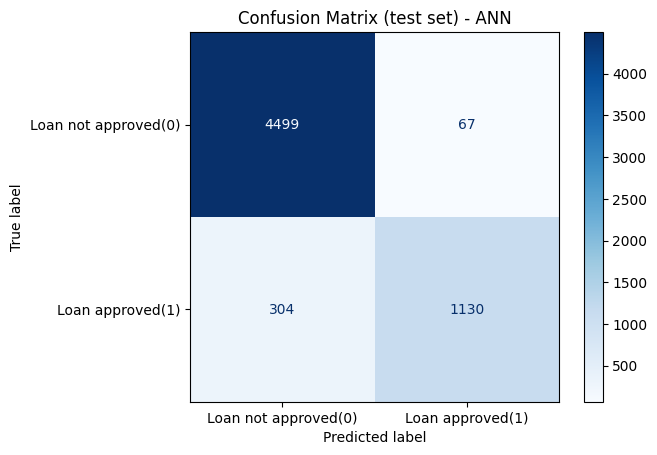

In [20]:
# =====================
# 11. Classification report and visualization on Test Data
# =====================

y_test_pred=model.predict(X_test)
y_test_pred=(y_test_pred[0]>=0.5).astype('int')
print(classification_report(y_test['Loan_approved'],y_test_pred))

cm=confusion_matrix(y_test['Loan_approved'],y_test_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Loan not approved(0)','Loan approved(1)']).plot(cmap='Blues')
plt.title("Confusion Matrix (test set) - ANN")
plt.show()

In [ ]:
🔹 Final Evaluation Summary:
1. The ANN model performed very well on the loan approval task. It correctly identified most of the rejected 
loan cases (class 0) with high recall (99%), which helps reduce financial risk. However, it missed some of 
the approved cases (class 1), with a recall of 79%, which is understandable in sensitive domains where false 
approvals can be risky.
2. For the second task — predicting risk score — the model achieved a low Mean Absolute Error (around 2.8 to 3.1), 
which shows it was quite accurate in estimating risk values.

    
🔹 Model Training Highlights
1. EarlyStopping was used to prevent overfitting.
2. The model trained for about 13 epochs, with best validation performance near epoch 12.
3. Validation accuracy ranged between 91% to 94%.
4. Risk score MAE on validation: around 3.0
    
🔹 Test Set Results
1. Overall Accuracy: 94%
2. Confusion Matrix: clearly shows strong performance on class 0.
3. Classification Report:
4. Class 0 (Loan Not Approved): Precision 94%, Recall 99%
5. Class 1 (Loan Approved): Precision 94%, Recall 79%

🔹 Final Thoughts
The neural network handled both classification and regression tasks effectively. While some approved cases were 
missed, the model prioritized minimizing risk, which is a valid tradeoff. The use of deep learning was appropriate 
and provided better performance than what is typically expected from simpler models.